In [17]:
from models import *
from train import *
from plot import *
from model_baseline import BaseLineNet
from model_siamese1 import SiameseConvNet1

In [18]:
# model = Siamese(fc_parameters={'input_size': 64})
model = model_kat = Siamese(conv_block_parameters={
    'ch1': 32, 'ch2': 64,
    'conv1_kernel': 3, 'conv2_kernel': 3,
    'use_max_pool1': True, 'max_pool1_kernel': 2, 'max_pool1_stride': 2
}, fc_parameters=
{
    'input_size': 1024, 'fc': 256, 'out': 10,
    'activation1': nn.ReLU(), 'activation2': nn.Softmax(dim=1),
    'use_batch_norm': False
})

baseline = BaseLineNet()

In [19]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

In [20]:
print(train_input[0:5].shape)

with torch.no_grad():
    pred_leq, (pred_class1, pred_class2) = model(train_input[0:5])
    print(pred_leq)
    print(pred_class1)
    print(pred_class2)
    # train the baseline model
    pred_leq, _ = baseline(train_input)

torch.Size([5, 2, 14, 14])
tensor([[0.4599],
        [0.4598],
        [0.4583],
        [0.4555],
        [0.4573]])
tensor([[0.0862, 0.1065, 0.0867, 0.0970, 0.1111, 0.1251, 0.0845, 0.1168, 0.0939,
         0.0921],
        [0.0991, 0.1051, 0.0789, 0.1020, 0.1016, 0.1314, 0.0814, 0.1011, 0.1027,
         0.0966],
        [0.0833, 0.0806, 0.0817, 0.1229, 0.1204, 0.1467, 0.0801, 0.1020, 0.0785,
         0.1039],
        [0.0946, 0.0815, 0.0711, 0.0957, 0.1116, 0.1397, 0.1058, 0.1113, 0.0783,
         0.1105],
        [0.0942, 0.0910, 0.0872, 0.0938, 0.1191, 0.1334, 0.0753, 0.1117, 0.0874,
         0.1069]])
tensor([[0.0837, 0.0840, 0.0854, 0.1233, 0.0996, 0.1232, 0.0815, 0.1085, 0.1115,
         0.0994],
        [0.0881, 0.1036, 0.0988, 0.1036, 0.0991, 0.1216, 0.0879, 0.1174, 0.0958,
         0.0843],
        [0.0818, 0.0975, 0.0697, 0.0959, 0.1093, 0.1437, 0.1021, 0.1148, 0.0920,
         0.0932],
        [0.1056, 0.0963, 0.0859, 0.1251, 0.0982, 0.1362, 0.0911, 0.1000, 0.0810,
        

In [21]:
summary(model, input_size=(1, 2, 14, 14))
summary(baseline, input_size=(1, 2, 14, 14))

Layer (type:depth-idx)                   Output Shape              Param #
BaseLineNet                              [1]                       --
├─Linear: 1-1                            [1, 150]                  58,950
├─Linear: 1-2                            [1, 80]                   12,080
├─Linear: 1-3                            [1, 20]                   1,620
├─Linear: 1-4                            [1, 1]                    21
Total params: 72,671
Trainable params: 72,671
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.29
Estimated Total Size (MB): 0.29

In [22]:
device = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
baseline.to(device)

# for the baseline model
start = time.perf_counter()
info_cycle = train_model(baseline,
                            train_input, train_target, train_classes,
                            nb_epochs=25, mini_batch_size=100,
                            criterion_classes=nn.CrossEntropyLoss(), criterion_leq=nn.BCELoss(),
                            optimizer= torch.optim.SGD(baseline.parameters(), lr=8e-2),
                            weight_loss_classes=0.0, weight_loss_pairs=1.0,
                            freeze_epochs=0,
                            one_hot_classes=True, one_hot_leq=False,
                            verbose=False,
                            test_input=test_input, test_target=test_target, test_classes=test_classes,
                            device=device)
end = time.perf_counter()
print(f'Time: {end - start:.2f}s')

# start = time.perf_counter()
# info_cycle = train_model(model,
#                             train_input, train_target, train_classes,
#                             nb_epochs=25, mini_batch_size=100,
#                             criterion_classes=nn.MSELoss(), criterion_leq=nn.MSELoss(),
#                             optimizer= None,
#                             weight_loss_classes=0.0, weight_loss_pairs=1.0,
#                             freeze_epochs=0,
#                             one_hot_classes=True, one_hot_leq=False,
#                             verbose=False,
#                             test_input=test_input, test_target=test_target, test_classes=test_classes,
#                             device=device)
# end = time.perf_counter()
# print(f'Time: {end - start:.2f}s')

Time: 0.95s


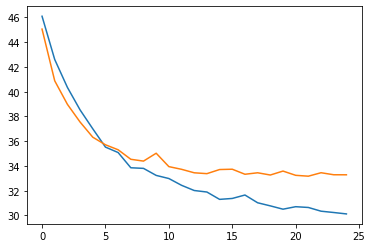

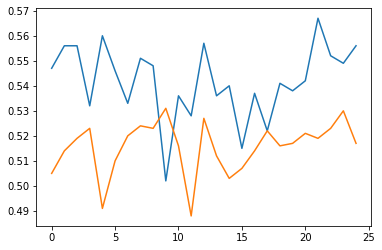

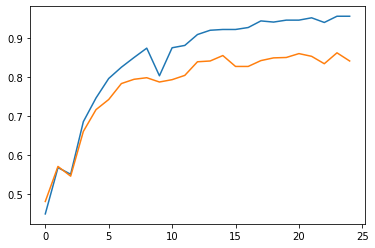

In [23]:
import matplotlib.pyplot as plt

plt.plot(info_cycle['train']['loss'])
plt.plot(info_cycle['test']['loss'])
plt.show()

# plt.plot(info_cycle['train']['acc_classes'])
# plt.plot(info_cycle['test']['acc_classes'])
# plt.show()

plt.plot(info_cycle['train']['acc_leq'])
plt.plot(info_cycle['test']['acc_leq'])
plt.show()

plt.plot(info_cycle['train']['acc_naive'])
plt.plot(info_cycle['test']['acc_naive'])
plt.show()
